In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
import tensorflow.keras.preprocessing as prep
from sklearn.model_selection import train_test_split
from model import AugementedConvLSTM
import h5py
import itertools

In [ ]:
# import netCDF4 as nc
# import xarray as xr
# import xesmf as xe
# import glob

# model = 'MIROC-ESM'
# files_list = glob.glob(rf"/home/uditbhatia/Documents/Sarth/Downscaling_AugmentedConvLSTM/02_Raw_Data/CMIP5 Data/pr_day_{model}_historical_r1i1p1_*.nc")
# print(f"{model}: {len(files_list)}")
# ds = xr.open_mfdataset(files_list,combine = 'by_coords')
# print(ds.dims)
# print(ds.coords)
# print()
# ds = ds.sel(time=((ds.time.dt.year >= 1948) & (ds.time.dt.year <= 2005)))
# print(ds.dims)
# print(ds.coords)
# print()
# # ds = ds.sel(time=~((ds.time.dt.month == 2) & (ds.time.dt.day == 29)))
# # ds = ds.sel(time=~((ds.time.dt.month == 2) & (ds.time.dt.day == 30)))
# lat_bnds, lon_bnds = [6, 39], [66, 100.5]
# ds = ds.sel(lat=slice(*lat_bnds), lon=slice(*lon_bnds))
# print(ds.dims)
# print(ds.coords)
# print()
# ds.to_netcdf(rf"MIROC-ESM.nc")
# print("****************************************************************************")
# print()
# ds.close()

# ds = xr.open_dataset(r"MIROC-ESM.nc")
# lat_bnds, lon_bnds = [6.5, 38.5], [66.5, 100]
# projection_dimension = [129, 135]
# lat_lst = np.linspace(lat_bnds[0], lat_bnds[1], projection_dimension[0])
# lon_lst = np.linspace(lon_bnds[0], lon_bnds[1], projection_dimension[1])

# dr = ds["pr"]
# ds_out = xr.Dataset(
#     {
#         "lat": (["lat"], lat_lst),
#         "lon": (["lon"], lon_lst),
#     }
# )
# regridder = xe.Regridder(ds, ds_out, "bilinear")
# dr_out = regridder(dr)
# dr_np = dr_out.to_numpy()
# np.save(
#     r"MIROC-ESM.npy",
#     dr_np
# )

In [2]:
def get_mask(mask = [1,1,1,1,1], rf_idx = 1):
    filepath = r"/home/uditbhatia/Documents/Sarth/Downscaling_AugmentedConvLSTM/05_Random_Field_India/Data"
    rf = np.array(np.load(os.path.join(filepath,rf"r{rf_idx}.npy")))
    X = np.empty((7,21185,129,135))
    X[0,:,:,:] = np.array(np.load(r"MIROC-ESM.npy")) if mask[0] else np.array(rf)
    X[1,:,:,:] = np.array(np.load(r"elev.npy")) if mask[1] else np.array(rf)
    X[2,:,:,:] = np.array(np.load(os.path.join(filepath,rf"rhum.npy"))) if mask[2] else np.array(rf)
    X[3,:,:,:] = np.array(np.load(os.path.join(filepath,rf"pres.npy"))) if mask[3] else np.array(rf)
    X[4,:,:,:] = np.array(np.load(os.path.join(filepath,rf"uwnd.npy"))) if mask[4] else np.array(rf)
    X[5,:,:,:] = np.array(np.load(os.path.join(filepath,rf"vwnd.npy"))) if mask[4] else np.array(rf)
    X[6,:,:,:] = np.array(np.load(os.path.join(filepath,rf"omega.npy"))) if mask[4] else np.array(rf)
    return X

In [3]:
def load_dataset(mask = [1,1,1,1,1], rf_idx = 1):
    X = get_mask(mask, rf_idx)
    Y = np.load(rf"/home/uditbhatia/Documents/Sarth/Downscaling_AugmentedConvLSTM/05_Random_Field_India/Data/IMD.npy")
    return X, Y

def normalize(data):
    data = data - data.mean()
    data = data / data.std()
    return data

def set_data(X, Y):
    X_normalized = np.zeros((7, 21185, 129, 135))
    for i in range(7):
        X_normalized[i,] = normalize(X[i,])

    Y_normalized = normalize(Y)

    print("Mean of GCM Data: ",X[0,].mean())
    print("Variance of GCM Data: ",X[0,].std(),end="\n")

    print("Mean of Obseved Data: ",Y.mean())
    print("Variance of Obseved Data: ",Y.std(),end="\n")

    std_observed = Y.std()
    X = X_normalized.transpose(1,2,3,0)
    Y = Y_normalized.reshape(-1,129, 135, 1)
    return X, Y, std_observed

In [4]:
Aug_ConvLSTM_model = AugementedConvLSTM(
    projection_height = 129, 
    projection_width = 135,
    timesteps=4
    )
model = Aug_ConvLSTM_model.model(
    [32, 16, 16], 
    [9,5,3], 
    [64,32,1], 
    [9,3,5], 
    2
    )

2022-06-27 12:14:23.045313: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-27 12:14:26.096587: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 8688 MB memory:  -> device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:18:00.0, compute capability: 7.5
2022-06-27 12:14:26.098110: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 9631 MB memory:  -> device: 1, name: GeForce RTX 2080 Ti, pci bus id: 0000:3b:00.0, compute capability: 7.5
2022-06-27 12:14:26.099233: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/r

In [5]:
model.load_weights('convlstm_weights_pr.h5')

In [6]:
def data_generator(X,Y):
    time_steps = 4
    batch_size1 = 1
    generator = prep.sequence.TimeseriesGenerator(
        X, 
        Y.reshape(-1, 129, 135, 1),
        length=time_steps, 
        batch_size=batch_size1
        )
    return generator

def get_yy_hat(mask, rf_idx, model, i):
    X, Y = load_dataset(mask, rf_idx)
    X, Y, std_observed = set_data(X, Y)
    generator = data_generator(X,Y)
    for xx, yy in itertools.islice(generator, 0, 1, 1):
        print(xx.shape, yy.shape)
    yy_hat = model.predict(generator)
    print(yy_hat.shape)
    np.save(rf"Data/yy_hat_{i}.npy", yy_hat)

In [7]:
from tqdm import tqdm
def get_RMSE(mask, rf_idx, i):
    X, Y = load_dataset(mask, rf_idx)
    X, Y, std_observed = set_data(X, Y)
    generator = data_generator(X,Y)
    yy_hat = np.load(rf"Data/yy_hat_{i}.npy")
    rmse = np.zeros((129,135))
    rmse_hist = np.zeros((yy_hat.shape[0],129,135))
    cnt = 0
    for xx, yy in tqdm(itertools.islice(generator, 0, None, 1)):
        yy_pred = yy_hat[cnt].reshape(129,135)
        yy = yy.reshape(129,135)
        rmse += np.square(yy - yy_pred)
        cnt += 1
        rmse_hist[cnt-1] = np.sqrt(rmse/cnt)
    rmse = np.sqrt(rmse/cnt)
    np.save(rf"Data/rmse_hist_{i}.npy", rmse_hist)
    plot_RMSE(i)
    
def plot_RMSE(i):
    rmse = np.load(rf"Data/rmse_hist_{i}.npy")[-1]
    FileName = r"/home/uditbhatia/Documents/Sarth/Downscaling_AugmentedConvLSTM/03_Preprocess_Data/npy_Files/SRTM.npy"
    mask = np.load(FileName)
    indices = np.where(mask == 0)
    rmse[indices] = np.nan
    fig,ax = plt.subplots(1,2, figsize = (20,10))
    sns.heatmap(np.flip(rmse, axis = 0), cmap = 'rainbow', ax =ax[0])
    # ax.set_facecolor("lightgray")
    ax[0].axis('off')
    ax[1].boxplot(rmse[~np.isnan(rmse)], vert = False)
    plt.suptitle(f"Random Field {i}", fontsize = 16)

In [ ]:
mask_list = [
    [0,1,1,1,1], # Pr, elev, rh, p, wnd
    [1,1,1,1,1],
]

In [8]:
get_yy_hat(
    [0,1,1,1,1], 
    1, 
    model, 
    1
    )

Mean of GCM Data:  0.0020574424924732857
Variance of GCM Data:  2.750453246896165
Mean of Obseved Data:  0.8932552446925094
Variance of Obseved Data:  5.906902817390205
(1, 4, 129, 135, 7) (1, 129, 135, 1)


2022-06-27 12:16:47.597454: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 7605
2022-06-27 12:16:49.951371: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Running ptxas --version returned 32512
2022-06-27 12:16:51.136913: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: ptxas exited with non-zero error code 32512, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


(21181, 129, 135, 1)


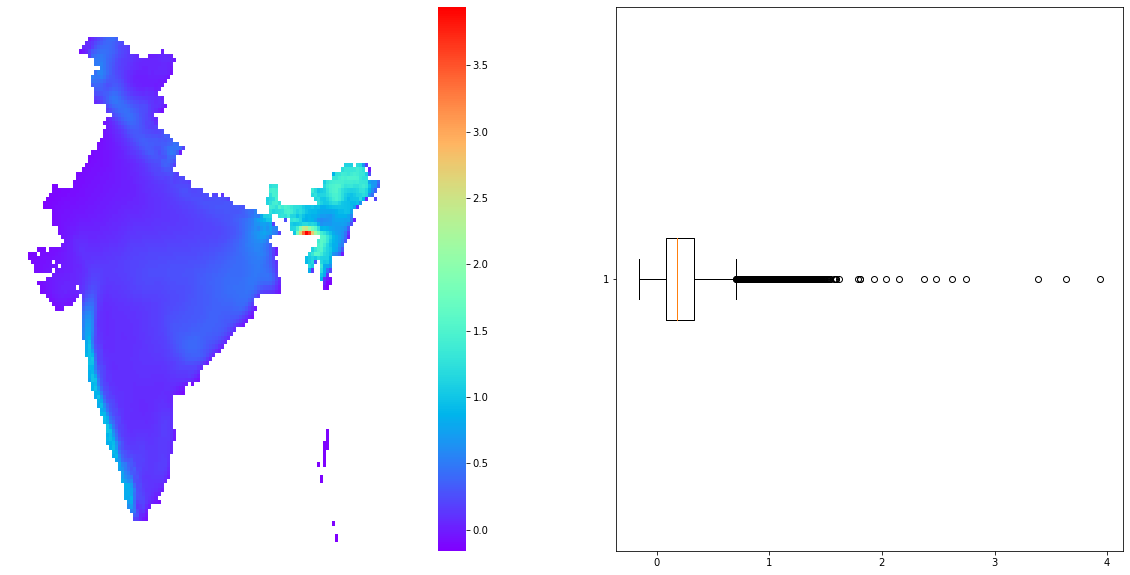

In [9]:
Y_hat = np.array(np.load(r"Data/yy_hat_1.npy").reshape(-1,129,135))
# data = np.array(np.sqrt(np.sum(np.square(((Y_hat*Y.std())+Y.mean()) - Y), axis = 0)/Y_hat.shape[0]))
data = np.array(np.mean(Y_hat, axis = 0))
FileName = r"/home/uditbhatia/Documents/Sarth/Downscaling_AugmentedConvLSTM/03_Preprocess_Data/npy_Files/SRTM.npy"
mask = np.load(FileName)
indices = np.where(mask == 0)
data[indices] = np.nan
fig,ax = plt.subplots(1,2, figsize = (20,10))
sns.heatmap(np.flip(data, axis = 0), cmap = 'rainbow', ax =ax[0])
ax[0].axis('off')
ax[1].boxplot(data[~np.isnan(data)], vert = False)
plt.show()

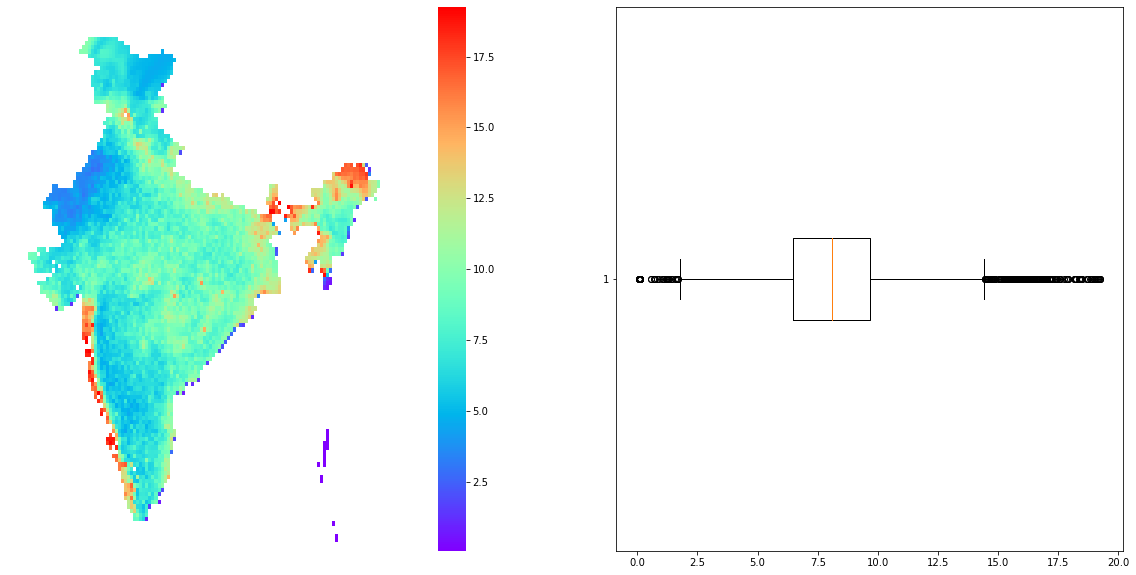

In [11]:
Y = np.load(rf"/home/uditbhatia/Documents/Sarth/Downscaling_AugmentedConvLSTM/05_Random_Field_India/Data/IMD.npy").reshape(21185,129,135)[4:]
Y_hat = np.array(np.load(r"Data/yy_hat_1.npy").reshape(-1,129,135))
data = np.array(np.sqrt(np.sum(np.square(((Y_hat*Y.std())+Y.mean()) - Y), axis = 0)/Y_hat.shape[0]))
FileName = r"/home/uditbhatia/Documents/Sarth/Downscaling_AugmentedConvLSTM/03_Preprocess_Data/npy_Files/SRTM.npy"
mask = np.load(FileName)
indices = np.where(mask == 0)
data[indices] = np.nan
threshold_99 = np.nanpercentile(data, 99)
indices = np.where(data > threshold_99)
data[indices] = np.nan
fig,ax = plt.subplots(1,2, figsize = (20,10))
sns.heatmap(np.flip(data, axis = 0), cmap = 'rainbow', ax =ax[0])
ax[0].axis('off')
ax[1].boxplot(data[~np.isnan(data)], vert = False)
plt.show()